In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import time

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
df = pd.read_csv("../dog_gi.csv")

In [3]:
df

,Unnamed: 0,year,week_number,total_count,gastroenteric,respiratory,pruritus,day,Lockdown,Lockdownoffset,date
0,0,2019,1,21782,705,212,937,0,0,-0.198925,01/01/2019
1,1,2019,2,20809,582,176,866,7,0,-0.198925,07/01/2019
2,2,2019,3,19854,609,153,834,14,0,-0.198925,14/01/2019
3,3,2019,4,18703,627,161,800,21,0,-0.198925,21/01/2019
4,4,2019,5,18825,573,147,703,28,0,-0.198925,28/01/2019
...,...,...,...,...,...,...,...,...,...,...,...
181,181,2022,25,14018,344,103,738,1267,0,-0.198925,13/06/2022
182,182,2022,26,14214,350,126,798,1274,0,-0.198925,20/06/2022
183,183,2022,27,14462,334,85,739,1281,0,-0.198925,27/06/2022
184,184,2022,28,13460,370,80,763,1288,0,-0.198925,04/07/2022


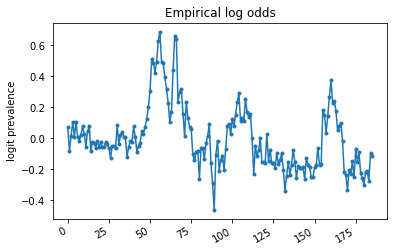

In [4]:
df["prev"] = df["gastroenteric"] / df["total_count"]
df["logit_prev"] = np.log(df["prev"]/(1-df["prev"]))
df["logit_prev_debiased"] = df["logit_prev"] - df["logit_prev"].mean()
df["logit_prev_debiased"].plot(marker=".")
plt.ylabel("logit prevalence")
plt.title("Empirical log odds")
plt.gcf().autofmt_xdate()

## Fourier transform

## Building model

In [28]:
def harmonic_matrix(t, num_harmonics, period=365):
    """
    Builds matrix of dummy harmonic variables
    
    t - a vector of times of length T
    num_harmonics - the value of number of harmonics
    period - period of the data, in the same units as 't'
    
    
    returns a [T, 2*num_harmonics] matrix
    """
    
    harmonics = 2*np.pi/period * np.arange(1.0, num_harmonics+1.0)
    t_harmonic = t[:, np.newaxis] * harmonics[np.newaxis, :]
    
    # Concatenate cos and sin functions by column
    harmonic_matrix = np.concatenate([np.cos(t_harmonic), 
                                      np.sin(t_harmonic)], axis=-1)
    
    return harmonic_matrix

__refdate = pd.to_datetime('2000-01-01')

def harmonic_model(y, t, n, design_matrix, l, mcmc_iter=5000, start={}):
    
    """
    Runs Harmonic Regression and Gaussian Process

    y - a vector of observed values
    t - a vector of times of length T
    n - a total number of trials per each timepoint
    design_matrix - a TxP matrix where T=t.shape[0]
    l - vector of binary offset values whether the UK was in a covid restriction or not
    mcmc_iter - number of itertions for mcmc sampler
    start - a dictionary of starting values for mcmc sampler
    
    returns dictionary of model, trace and predictions
    """
    
    
    num_covariates = design_matrix.shape[-1]
    
    with pm.Model() as model:
        
        #sample prior distributions
        coefficients = pm.Normal('coefficients', 0, 100, shape=num_covariates)
        length_scale = pm.HalfNormal('length_scale', sigma=10)
        gp_variance = pm.HalfNormal('gp_variance', sigma=1)
        observation_noise_variance = pm.HalfNormal('observation_noise_variance', sigma=10)
        lockdown = pm.Normal('lockdown', 0, 100)
        
        #create kernels for gaussian process
        kernel_correlated = gp_variance * pm.gp.cov.Matern32(1, length_scale)
        kernel_noise = pm.gp.cov.WhiteNoise(observation_noise_variance)
        
        #running gaussian process
        gp_u = pm.gp.Latent(cov_func=kernel_correlated)
        gp_epsilon = pm.gp.Latent(cov_func=kernel_noise)
        gp = gp_u + gp_epsilon
        
        t_column = t[:, None]
        s = gp.prior("gp", X=t_column)        
        
        #dt product of harmonic matrix and coefficents + gp + lockdown
        mean_t = (design_matrix @ coefficients) + s + (lockdown * l)
        
        #coditioning on data
        yobs = pm.Binomial("yobs", n=n, p=pm.invlogit(mean_t), observed=y)

        #sample mcmc
        trace = pm.sample(mcmc_iter,
                          chains=1,
                          start=start,
                          tune=1000)
        
        #prediction ------
        s_star = gp.conditional('s_star', t[:, None])
        pi_star = pm.Deterministic('pi_star', pm.invlogit(s_star))
        
        u_star = gp_u.conditional("u_star", 
                                  Xnew=t[:, None], 
                                  given=dict(X=t[:, None],
                                             y=s,
                                             noise=observation_noise_variance,
                                             gp=gp)
                                 )
        pred = pm.sample_posterior_predictive(trace, var_names=['yobs', 's_star', 'pi_star', 'u_star'])
        
        
        return {'model': model, 'trace': trace, 'pred': pred}
    


In [30]:
times = np.arange(df.shape[0])*7.0

design_matrix = np.concatenate(
    [
        np.ones((df.shape[0],1)),  # Ones vector for intercept
        times[:, np.newaxis] - np.mean(times),  # Centred time
        harmonic_matrix(times, num_harmonics=5), # Harmonic matrix
    ],
    axis=-1
)


In [32]:
model = harmonic_model(df['gastroenteric'], times, df["total_count"], design_matrix, df['Lockdownoffset']) 

<ipython-input-28-8e95400eeaef>:71: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(mcmc_iter,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [gp_rotated_, lockdown, observation_noise_variance, gp_variance, length_scale, coefficients]


Sampling 1 chain for 5 tune and 0 draw iterations (5 + 0 draws total) took 58 seconds.
No posterior samples. Unable to run convergence checks


AttributeError: 'X' not set.  Provide as argument to condition, or call 'prior' first

In [41]:
unpickled_df = pd.read_pickle("../harmonicresultsnew.pkl") 

<ipython-input-42-405036852470>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(unpickled_df['trace'])
C:\Users\appleto1\AppData\Roaming\Python\Python39\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\Users\appleto1\AppData\Roaming\Python\Python39\site-packages\arviz\data\io_pymc3.py:329: UserWarning: Could not compute log_likelihood, it will be omitted. Check your model object or set log_likelihood=False
  warnings.warn(warn_msg)


array([[<AxesSubplot:title={'center':'coefficients'}>,
        <AxesSubplot:title={'center':'coefficients'}>],
       [<AxesSubplot:title={'center':'lockdown'}>,
        <AxesSubplot:title={'center':'lockdown'}>],
       [<AxesSubplot:title={'center':'gp_rotated_'}>,
        <AxesSubplot:title={'center':'gp_rotated_'}>],
       [<AxesSubplot:title={'center':'length_scale'}>,
        <AxesSubplot:title={'center':'length_scale'}>],
       [<AxesSubplot:title={'center':'gp_variance'}>,
        <AxesSubplot:title={'center':'gp_variance'}>],
       [<AxesSubplot:title={'center':'observation_noise_variance'}>,
        <AxesSubplot:title={'center':'observation_noise_variance'}>],
       [<AxesSubplot:title={'center':'gp'}>,
        <AxesSubplot:title={'center':'gp'}>]], dtype=object)

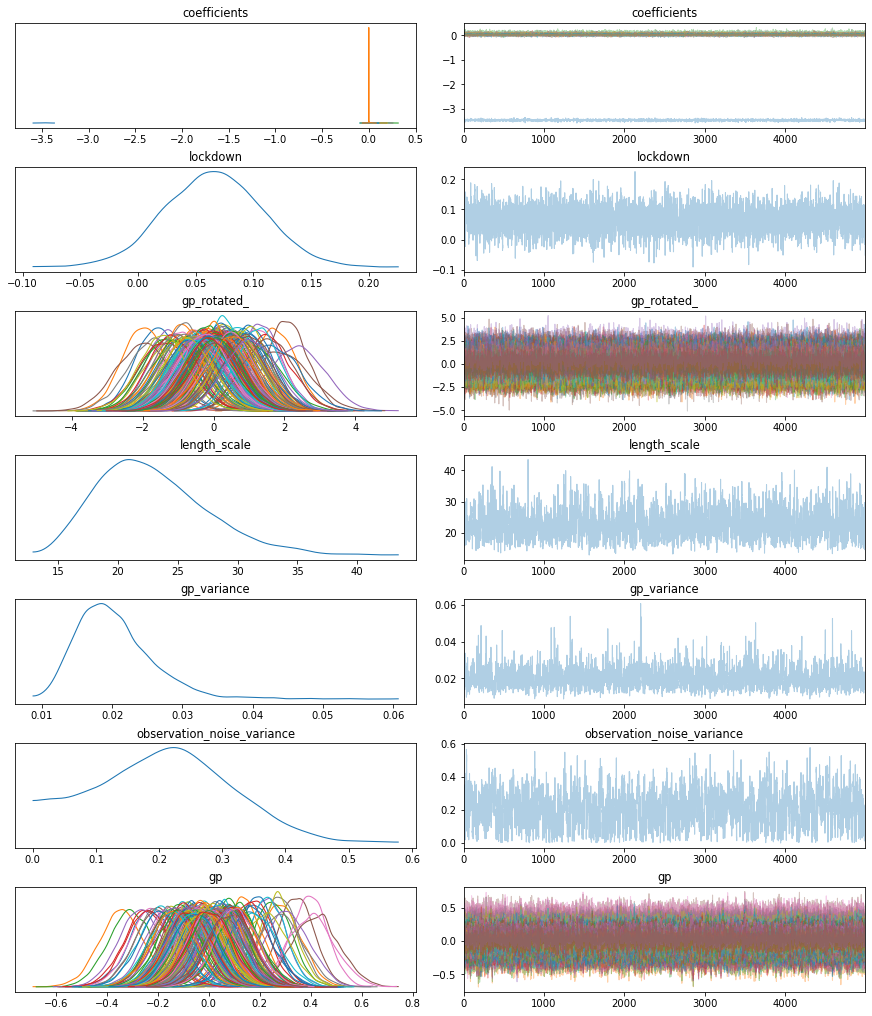

In [42]:
pm.traceplot(unpickled_df['trace'])

exceed prob size: (186,)


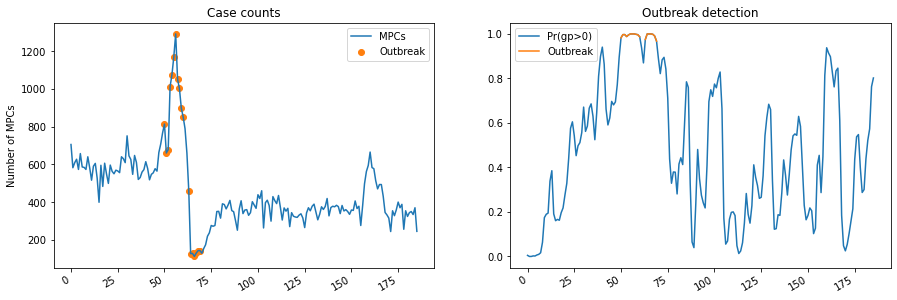

In [61]:
def mask_posterior_exceedance(posterior_gp, threshold=0.0, prob=0.95):
    exceed_prob = (posterior_gp > threshold).mean(axis=0)
    print("exceed prob size:", exceed_prob.shape)
    not_exceed_flag = exceed_prob < prob
    exceed_prob[not_exceed_flag] = np.nan
    return exceed_prob

#mindate = pd.to_datetime('2019-01-01')
#X = df['day']
#ts = slice(0,X.shape[0])
#x = np.array([mindate + pd.Timedelta(d,unit='D') for d in X[ts]])

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
exceedance_mask = mask_posterior_exceedance(unpickled_df['pred']['s_star'])
ax[0].plot(df["gastroenteric"], label="MPCs")
ax[0].scatter(df.index[~np.isnan(exceedance_mask)], 
              df["gastroenteric"][~np.isnan(exceedance_mask)],
              color="C1",
              label="Outbreak")
ax[0].set_ylabel("Number of MPCs")
ax[0].set_title("Case counts")
ax[0].legend()
ax[1].plot(df.index,
           np.mean((unpickled_df['pred']['s_star']) > 0, axis=0),
           label="Pr(gp>0)")
ax[1].plot(df.index, exceedance_mask, label="Outbreak")
ax[1].set_title("Outbreak detection")
ax[1].legend()
plt.gcf().autofmt_xdate()

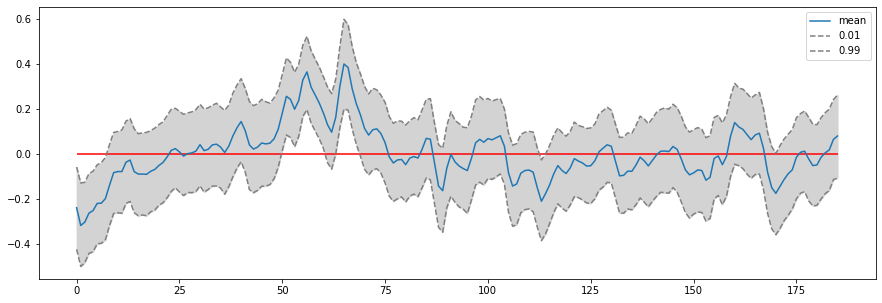

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(df.index, unpickled_df['pred']['s_star'].mean(axis=0), label="mean")
qtiles = np.quantile(unpickled_df['pred']['s_star'], q=(0.025, 0.975), axis=0)
ax.plot(df.index, qtiles[0], color="grey", linestyle="--", label="0.01")
ax.plot(df.index, qtiles[1], color="grey", linestyle="--", label="0.99")
ax.fill_between(df.index, qtiles[0], qtiles[1], color="lightgrey")
ax.hlines(0, xmin=df.index.min(), xmax=df.index.max(), color="red")
ax.legend()

# Chris' data selection 

In [66]:
dogs = pd.read_csv("dogs20162020.csv")

In [64]:
unpickled_dfchrisdata = pd.read_pickle("../harmonicresultschrisdata.pkl") 

exceed prob size: (209,)


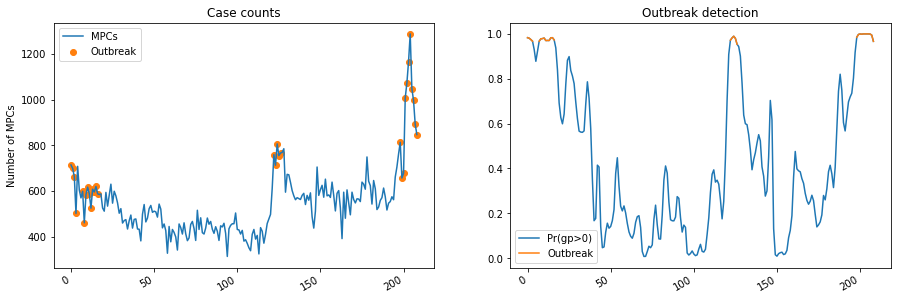

In [68]:
def mask_posterior_exceedance(posterior_gp, threshold=0.0, prob=0.95):
    exceed_prob = (posterior_gp > threshold).mean(axis=0)
    print("exceed prob size:", exceed_prob.shape)
    not_exceed_flag = exceed_prob < prob
    exceed_prob[not_exceed_flag] = np.nan
    return exceed_prob

#mindate = pd.to_datetime('2019-01-01')
#X = df['day']
#ts = slice(0,X.shape[0])
#x = np.array([mindate + pd.Timedelta(d,unit='D') for d in X[ts]])

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
exceedance_mask = mask_posterior_exceedance(unpickled_dfchrisdata['pred']['s_star'])
ax[0].plot(dogs["gastroenteric"], label="MPCs")
ax[0].scatter(dogs.index[~np.isnan(exceedance_mask)], 
              dogs["gastroenteric"][~np.isnan(exceedance_mask)],
              color="C1",
              label="Outbreak")
ax[0].set_ylabel("Number of MPCs")
ax[0].set_title("Case counts")
ax[0].legend()
ax[1].plot(dogs.index,
           np.mean((unpickled_dfchrisdata['pred']['s_star']) > 0, axis=0),
           label="Pr(gp>0)")
ax[1].plot(dogs.index, exceedance_mask, label="Outbreak")
ax[1].set_title("Outbreak detection")
ax[1].legend()
plt.gcf().autofmt_xdate()

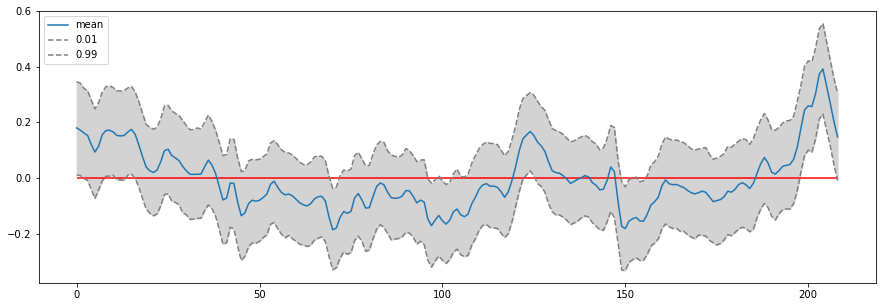

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(dogs.index, unpickled_dfchrisdata['pred']['s_star'].mean(axis=0), label="mean")
qtiles = np.quantile(unpickled_dfchrisdata['pred']['s_star'], q=(0.025, 0.975), axis=0)
ax.plot(dogs.index, qtiles[0], color="grey", linestyle="--", label="0.01")
ax.plot(dogs.index, qtiles[1], color="grey", linestyle="--", label="0.99")
ax.fill_between(dogs.index, qtiles[0], qtiles[1], color="lightgrey")
ax.hlines(0, xmin=dogs.index.min(), xmax=dogs.index.max(), color="red")
ax.legend()

# Checking de sensing

In [71]:
mpc = pd.read_json("../datasets/mpc_20-10-2022.json.gz")
mpc_agg = mpc.groupby(["species", "location", "date"]).agg("sum")
dogs20182022 = mpc_agg.loc["dog"].groupby(level=1).sum()["2018-08-01":"2022-10-20"]

In [72]:
dogs20182022.to_csv("../datasets/dogs20182022.csv")

In [73]:
unpickled_df20182022 = pd.read_pickle("../datasets/harmonicresults20182022.pkl") 

exceed prob size: (220,)


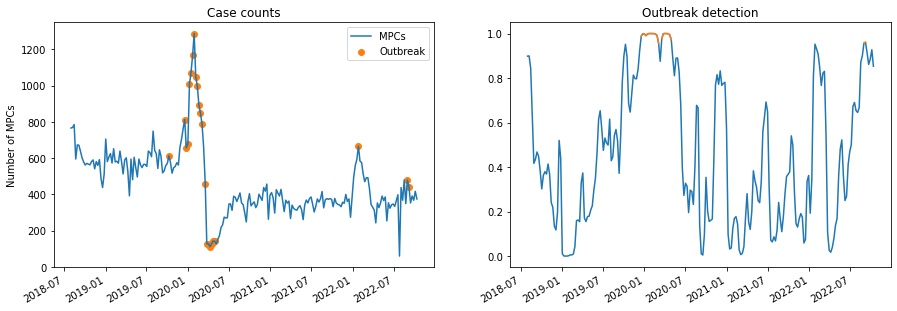

In [77]:
def mask_posterior_exceedance(posterior_gp, threshold=0.0, prob=0.95):
    exceed_prob = (posterior_gp > threshold).mean(axis=0)
    print("exceed prob size:", exceed_prob.shape)
    not_exceed_flag = exceed_prob < prob
    exceed_prob[not_exceed_flag] = np.nan
    return exceed_prob

#mindate = pd.to_datetime('2019-01-01')
#X = df['day']
#ts = slice(0,X.shape[0])
#x = np.array([mindate + pd.Timedelta(d,unit='D') for d in X[ts]])

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
exceedance_mask = mask_posterior_exceedance(unpickled_df20182022['pred']['s_star'])
ax[0].plot(dogs20182022["gastroenteric"], label="MPCs")
ax[0].scatter(dogs20182022.index[~np.isnan(exceedance_mask)], 
              dogs20182022["gastroenteric"][~np.isnan(exceedance_mask)],
              color="C1",
              label="Outbreak")
ax[0].set_ylabel("Number of MPCs")
ax[0].set_title("Case counts")
ax[0].legend()
ax[1].plot(dogs20182022.index,
           np.mean((unpickled_df20182022['pred']['s_star']) > 0, axis=0),
           label="Pr(gp>0)")
ax[1].plot(dogs20182022.index, exceedance_mask, label="Outbreak")
ax[1].set_title("Outbreak detection")
#ax[1].legend()
plt.gcf().autofmt_xdate()

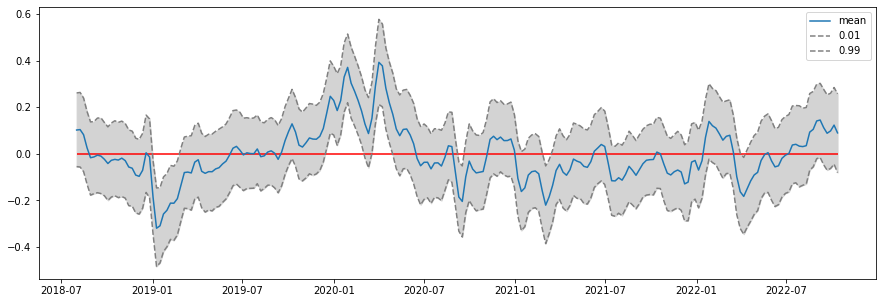

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(dogs20182022.index, unpickled_df20182022['pred']['s_star'].mean(axis=0), label="mean")
qtiles = np.quantile(unpickled_df20182022['pred']['s_star'], q=(0.025, 0.975), axis=0)
ax.plot(dogs20182022.index, qtiles[0], color="grey", linestyle="--", label="0.01")
ax.plot(dogs20182022.index, qtiles[1], color="grey", linestyle="--", label="0.99")
ax.fill_between(dogs20182022.index, qtiles[0], qtiles[1], color="lightgrey")
ax.hlines(0, xmin=dogs20182022.index.min(), xmax=dogs20182022.index.max(), color="red")
ax.legend()